In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path # dealing with directories

In [ ]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
# Unzipping the data
!unzip -q "archive.zip"

--2023-02-18 01:04:05--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2023-02-18 01:04:05--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc586244370953455afd9e10289c.dl.dropboxusercontent.com/cd/0/inline/B2vPY1T9RFSX7ivoIGl-kIuOCiVAhhUdN_EBqW7PxLycn5K6gzelHpJD9bRWGjFHx66HDzbHcbXQcMr3rk33jfNZsYlXTbfh_3Y8PemHH8c3VLPgFmPqWdpXMtPBSfg3dpZ5WBHG7Y7Ds_1TCc1SSE9BZpMs6p9Yar7i4Jph9VDIHw/file# [following]
--2023-02-18 01:04:05--  https://uc586244370953455afd9e10289c.dl.dropboxusercontent.com/cd/0/inline/B2vPY1T9RFSX7ivoIGl-kIuOCiVAhhUdN_EBqW7PxLycn5K6gzelHpJD9bRWGjFHx66HDzbHcbXQcMr3rk3

Dataste: 5800 images

In [ ]:
train = Path('/content/chest_xray/train')
val = Path('/content/chest_xray/val')

In [ ]:
# iterate over directories to match patterns, collecting paths inside 'normal ' and 'pneumonia' folders
train = train.glob('*/*') # returns the files
val = val.glob('*/*')
train

<generator object Path.glob at 0x7f9b609f6350>

In [ ]:
# convert paths to strings
train = list(map(lambda x: str(x), train))
val = list(map(lambda x: str(x), val))

train[:3]

['/content/chest_xray/train/PNEUMONIA/person88_virus_164.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person324_virus_658.jpeg',
 '/content/chest_xray/train/PNEUMONIA/person507_bacteria_2141.jpeg']

In [ ]:
len(train)

5216

In [ ]:
len(val)

16

In [ ]:
labels = {'NORMAL': 0, 'PNEUMONIA': 1}
INVLABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def label(path: str) -> int:
  return labels[path.split("/")[-2]]

train_labels = list(map(lambda x : label(x) , train))
val_labels = list(map(lambda x : label(x) , val))

print(train_labels[:5])

[1, 1, 1, 1, 1]


In [ ]:
BS = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image) 
    image = tf.io.decode_jpeg(image , channels = 3) 
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image) # augmentation
    return image , label

# Function used to Create a Tensorflow Data Object
def dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BS)

    return dataset

In [ ]:
train_ds = dataset(train , train_labels)
image , label = next(iter(train_ds))
print(image.shape)
print(label.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(32, 224, 224, 3)
(32,)


'PNEUMONIA'

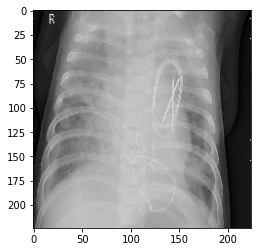

In [ ]:
plt.imshow(image[11].numpy().reshape(224 , 224 , 3))
INVLABELS[label[11].numpy()]

In [ ]:
val_ds = dataset(val , val_labels , train = False)

Image , Label = next(iter(val_ds))
print(Image.shape)
print(Label.shape)

(16, 224, 224, 3)
(16,)


'PNEUMONIA'

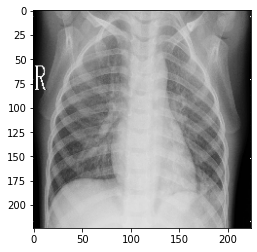

In [ ]:
plt.imshow(Image[11].numpy().reshape(224 , 224 , 3))
INVLABELS[Label[11].numpy()]

In [ ]:
# build a Resnet model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential 
from tensorflow.keras.layers import Flatten

m = ResNet50(
    include_top=False,
    input_shape=(224,224,3)
    )

model = Sequential([
    m,
    layers.MaxPooling2D(),
    Flatten(),
    layers.Dense(1, activation = 'sigmoid')
])

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 2048)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 1)                 18433     
                                                                 
Total params: 23,606,145
Trainable params: 23,553,025
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
import tensorflow.keras.callbacks

f = model.fit(
    train_ds,
    steps_per_epoch = len(train_ds)//BS,
    validation_data=val_ds,
    validation_steps = len(val_ds)//BS,
    epochs = 15
    )

Epoch 1/15
5/5 [==============================] - 56s 304ms/step - loss: 0.1204 - accuracy: 0.9500
Epoch 2/15
5/5 [==============================] - 1s 288ms/step - loss: 6.1249e-33 - accuracy: 1.0000
Epoch 3/15
5/5 [==============================] - 1s 288ms/step - loss: 2.8993e-33 - accuracy: 1.0000
Epoch 4/15
5/5 [==============================] - 1s 288ms/step - loss: 5.7367e-34 - accuracy: 1.0000
Epoch 5/15
5/5 [==============================] - 1s 289ms/step - loss: 3.0934e-32 - accuracy: 1.0000
Epoch 6/15
5/5 [==============================] - 2s 319ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/15
5/5 [==============================] - 2s 385ms/step - loss: 1.4817 - accuracy: 0.9812
Epoch 8/15
5/5 [==============================] - 2s 309ms/step - loss: 1.0104 - accuracy: 0.9438
Epoch 9/15
5/5 [==============================] - 2s 322ms/step - loss: 0.3304 - accuracy: 0.9500
Epoch 10/15
5/5 [==============================] - 2s 356ms/step - loss: 0.2222 - accuracy: 0.900